In [9]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import rasterio as rio
import rioxarray
import math
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import pandas as pd
import os

import deep_snow.models
from deep_snow.utils import calc_norm, undo_norm, calc_dowy
from deep_snow.dataset import norm_dict
from tqdm import tqdm
import shutil

/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/ayushg/miniforge3/envs/deep-snow/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/ayushg/miniforge3/envs/deep-snow/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warnin

#### Creating Random Grid for Sampling

In [ ]:
X_coords = np.arange(np.random.randint(-160, -140), 128+160, 30)
Y_coords = np.arange(np.random.randint(-160, -140), 128+160, 30)
xv, yv = np.meshgrid(X_coords, Y_coords)
xv, yv = xv.flatten(), yv.flatten()

rot = np.deg2rad(65) 

xv_rot = (xv*np.cos(rot) + yv*np.sin(rot)).astype('int')
yv_rot = (yv*np.cos(rot) - xv*np.cos(rot)).astype('int')

mask1 = (xv>0)&(xv<128)&(yv>0)&(yv<128)
mask2 = (xv_rot>0)&(xv_rot<128)&(yv_rot>0)&(yv_rot<128)

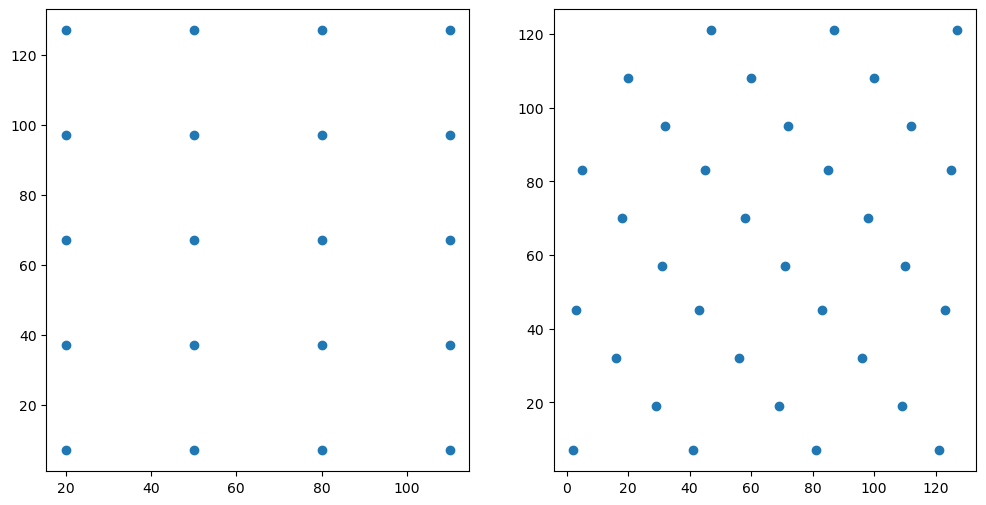

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(xv[mask1], yv[mask1])
axs[1].scatter(xv_rot[mask2], yv_rot[mask2])

In [49]:
# we see the directory below contains our ai-ready data
files = glob("/Users/ayushg/Desktop/Courses/ML_GEO/mlgeo-2024-deep-snow/final_data/jack_subsets 2/ncs/*.nc")
len(files)

3540

#### Saving to pickle file

In [ ]:
def random_grid(grid_sz_x=30, grid_sz_y=30):
    # Hard coded patch size
    X_coords = np.arange(np.random.randint(-160, -140), 128+160, grid_sz_x)
    Y_coords = np.arange(np.random.randint(-160, -140), 128+160, grid_sz_y)
    xv, yv = np.meshgrid(X_coords, Y_coords)
    xv, yv = xv.flatten(), yv.flatten()

    rot = np.deg2rad(np.random.randint(0, 50)) 

    xv_rot = (xv*np.cos(rot) + yv*np.sin(rot)).astype('int')
    yv_rot = (yv*np.cos(rot) - xv*np.cos(rot)).astype('int')
    mask2 = (xv_rot>0)&(xv_rot<128)&(yv_rot>0)&(yv_rot<128)

    return xv_rot[mask2], yv_rot[mask2]

In [137]:
dataset_list = {}
# xgrid, ygrid, file_list = [], [], []
for i, file in enumerate(files):
    filenm = file.split('/')[-1].replace('.nc', '')
    xv, yv = random_grid()
    dataset_list[filenm] = { 'x_idx': list(xv), 'y_idx': list(yv) }

In [145]:
import pickle
out_path = '/Users/ayushg/Desktop/Courses/ML_GEO/mlgeo-2024-deep-snow/final_data/jack_subsets 2/dataset_index.pkl'
with open(out_path, "wb") as fp:
    pickle.dump(dataset_list, fp)

In [151]:
# Read dictionary pkl file
with open(out_path, 'rb') as fp:
    dataset_idx = pickle.load(fp)

In [154]:
# dataset_idx

#### Dataset Class

In [150]:
norm_dict = {'aso_sd':[0, 25],
             'vv':[-59, 30],
             'vh':[-65, 17],
             'cr':[-43, 16],
             'delta_cr':[-33, 27],
             'AOT':[0, 572],
             'coastal':[0, 24304],
             'blue':[0, 23371],
             'green':[0, 26440],
             'red':[0, 21576],
             'red_edge1':[0, 20796],
             'red_edge2':[0, 20432],
             'red_edge3':[0, 20149],
             'nir':[0, 21217],
             'water_vapor':[0, 18199],
             'swir1':[0, 17669],
             'swir2':[0, 17936],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6518],
             'elevation':[-100, 9000],
             'aspect':[0, 360],
             'slope':[0, 90],
             'curvature':[-22, 22],
             'tpi':[-164, 167],
             'tri':[0, 913],
             'latitude':[-90, 90],
             'longitude':[-180, 180],
             'dowy': [0, 365]}

# Process each file and normalize the relevant features
def process_file(file_path):
    ds = xr.open_dataset(file_path)
    # Normalize features using the norm_dict
    data_dict = {}
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['slope'] = calc_norm(torch.Tensor(ds['slope'].values), norm_dict['slope'])
    data_dict['tri'] = calc_norm(torch.Tensor(ds['tri'].values), norm_dict['tri'])
    data_dict['tpi'] = calc_norm(torch.Tensor(ds['tpi'].values), norm_dict['tpi'])
    data_dict['dowy'] = calc_norm(torch.Tensor(ds['dowy'].values), norm_dict['dowy'])
    # Reshape PC components to 2D
    s1_pc1_2d = ds['s1_pc1'].values.reshape(128, 128)
    s1_pc2_2d = ds['s1_pc2'].values.reshape(128, 128)
    s2_pc1_2d = ds['s2_pc1'].values.reshape(128, 128)
    s2_pc2_2d = ds['s2_pc2'].values.reshape(128, 128)
    s2_pc3_2d = ds['s2_pc3'].values.reshape(128, 128)
    # Stack normalized features
    features = np.stack([
        data_dict['elevation'].numpy(),
        data_dict['slope'].numpy(),
        data_dict['tri'].numpy(),
        data_dict['tpi'].numpy(),
        data_dict['latitude'].numpy(),
        data_dict['longitude'].numpy(),
        s1_pc1_2d,
        s1_pc2_2d,
        s2_pc1_2d,
        s2_pc2_2d,
        s2_pc3_2d,
        data_dict['dowy'].numpy()
    ], axis=0)
    target = ds['aso_sd'].values
    return features, target

In [172]:
from torch.utils.data import DataLoader, Dataset

class SparseSnowDataset(Dataset):
    """Sparse Snow Depth dataset"""
    def __init__(self, datapath, mode):
        self.datapath = datapath
        self.data_files = glob(f'{datapath}/ncs/*.nc')

        # Calculate the sizes for each split
        train_size = int(0.7 * len(self.data_files))  # 70% for training
        test_size = int(0.2 * len(self.data_files))   # 20% for testing
        val_size = len(self.data_files) - train_size - test_size  # Remaining 10% for validation

        # Setting modes
        if mode=='train':
            self.data_files = self.data_files[:train_size]
        elif mode=='test':
            self.data_files = self.data_files[train_size:train_size + test_size]
        elif mode=='val':
            self.data_files = self.data_files[train_size + test_size:]

        # Read dictionary pkl file
        with open(f'{datapath}/dataset_index.pkl', 'rb') as fp:
            self.dataset_idx = pickle.load(fp)

    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, index):
        file_name = self.data_files[index]
        features, target = process_file(file_name)
        xy_grid = self.dataset_idx[file_name.split('/')[-1].replace('.nc', '')]
        x_idx, y_idx = xy_grid['x_idx'], xy_grid['y_idx']
        return features, target, [x_idx, y_idx]

In [176]:
data_path = '/Users/ayushg/Desktop/Courses/ML_GEO/mlgeo-2024-deep-snow/final_data/jack_subsets 2'

train_snow_dataset = SparseSnowDataset(data_path, 'train')
val_snow_dataset = SparseSnowDataset(data_path, 'val')
test_snow_dataset = SparseSnowDataset(data_path, 'test')

# Create data loaders
train_loader = DataLoader(train_snow_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_snow_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_snow_dataset, batch_size=32, shuffle=False)